<a href="https://colab.research.google.com/github/JiseonByeon96/PersonalProject/blob/main/%EC%84%B8%EC%A2%85%EC%8B%9C_%EC%95%84%ED%8C%8C%ED%8A%B8_%EB%A7%A4%EB%A7%A4_%EC%8B%A4%EA%B1%B0%EB%9E%98%EB%9F%89_XGBoost_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XGBoost 전처리

In [1]:
pip install xgboost

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier

In [69]:
data = pd.read_csv('/content/아파트매매.csv', encoding='cp949')
data.drop(['계약년월', '계약일', '시군구', '본번', '부번', '단지명','전용면적(㎡)', '층', '건축년도', '동.1'], axis=1, inplace=True)
data.info()
data['계약년월일'] = data['계약년월일'].astype('str')
data['계약년월일'] = pd.to_datetime(data['계약년월일'])
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21140 entries, 0 to 21139
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   거래금액(만원)  21140 non-null  int64 
 1   동         21140 non-null  object
 2   계약년월일     21140 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 495.6+ KB


,거래금액(만원),동,계약년월일
0,8600,보람동,2017-01-01
1,27300,종촌동,2017-01-01
2,32000,고운동,2017-01-02
3,30500,고운동,2017-01-02
4,31300,아름동,2017-01-02
...,...,...,...
21135,50000,조치원읍,2020-10-27
21136,23500,조치원읍,2020-10-27
21137,68000,도담동,2020-10-28
21138,6500,부강면,2020-10-28


In [ ]:
data.set_index('계약년월일')
data['month'] = data.index.month
data['year'] = data.index.year
data['dayofweek'] = data.index.dayofweek

In [71]:
data

,거래금액(만원),동,month,year,dayofweek
계약년월일,,,,,
2017-01-01,8600,보람동,1,2017,6
2017-01-01,27300,종촌동,1,2017,6
2017-01-02,32000,고운동,1,2017,0
2017-01-02,30500,고운동,1,2017,0
2017-01-02,31300,아름동,1,2017,0
...,...,...,...,...,...
2020-10-27,50000,조치원읍,10,2020,1
2020-10-27,23500,조치원읍,10,2020,1
2020-10-28,68000,도담동,10,2020,2


In [81]:
# 레이블인코딩
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(data['동'])
data['동']=encoder.transform(data['동'])

In [82]:
data

,거래금액(만원),동,month,year,dayofweek,labels
계약년월일,,,,,,
2017-01-01,8600,7,1,2017,6,7
2017-01-01,27300,20,1,2017,6,20
2017-01-02,32000,0,1,2017,0,0
2017-01-02,30500,0,1,2017,0,0
2017-01-02,31300,12,1,2017,0,12
...,...,...,...,...,...,...
2020-10-27,50000,19,10,2020,1,19
2020-10-27,23500,19,10,2020,1,19
2020-10-28,68000,5,10,2020,2,5


In [79]:
encoder.classes_ # 인코딩된 원래의 클래스명

array(['고운동', '금남면', '나성동', '다정동', '대평동', '도담동', '반곡동', '보람동', '부강면',
       '새롬동', '소담동', '소정면', '아름동', '어진동', '연동면', '연서면', '장군면', '전동면',
       '전의면', '조치원읍', '종촌동', '한솔동'], dtype=object)

In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21140 entries, 2017-01-01 to 2020-10-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   거래금액(만원)   21140 non-null  int64
 1   동          21140 non-null  int64
 2   month      21140 non-null  int64
 3   year       21140 non-null  int64
 4   dayofweek  21140 non-null  int64
 5   labels     21140 non-null  int64
dtypes: int64(6)
memory usage: 1.8 MB


In [88]:
# XGBoost 전처리

split = "2020-05-30"
data_train = data[:split]
data_test = data[split:]
data
data_train_y = data_train.loc[:, '거래금액(만원)']
data_train_x = data_train.drop('거래금액(만원)', axis=1)
data_test_y = data_test.loc[:,'거래금액(만원)']
data_test_x = data_test.drop('거래금액(만원)', axis=1)
data_test_orig = data_test.loc[:, ['동', '거래금액(만원)']]

In [89]:
XG_model_month = xgb.XGBRegressor(n_estimators=1000)

In [90]:
XG_model_month.fit(data_train_x, data_train_y, eval_set=[(data_test_x, data_test_y)], early_stopping_rounds=50,verbose=False)

[07:56:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

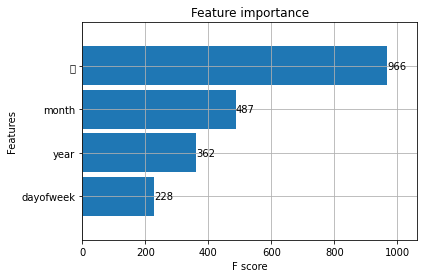

In [91]:
# 주요하게 적용하는 변수를 판단
plot_importance(XG_model_month, height=0.9)

In [113]:
# 테스트 데이터 중 특정 동 데이터를 추출
df1 = data_test_x[(data_test_x.동==1)]
xgboost = XG_model_month.predict(df1)


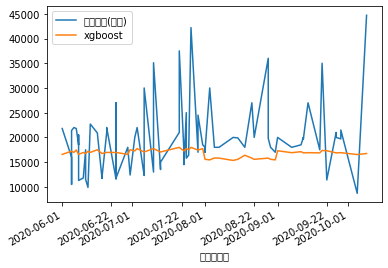

In [114]:
result=pd.concat([data_test_orig[(data_test_orig.동==1)].reset_index(), pd.DataFrame(xgboost, columns=['xgboost'])], axis=1, ignore_index=False)
result = result.set_index('계약년월일')
result = result.loc[:, ['거래금액(만원)', 'xgboost']]
result.plot()